# SC4001 Project: Protein Structure Prediction

## Data Preprocessing

In [19]:
# Core libraries
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

# PyTorch utilities
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim

# Utilities
from copy import deepcopy
import math
from pprint import pprint
import random
from typing import Dict, List, Tuple

In [2]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [20]:
train_data = pd.read_csv("./data/processed/train.csv")
val_data = pd.read_csv("./data/processed/val.csv")
test_data = pd.read_csv("./data/processed/test.csv")

In [21]:
print(train_data["has_nonstd_aa"].value_counts())
print(val_data["has_nonstd_aa"].value_counts())
print(test_data["has_nonstd_aa"].value_counts())

has_nonstd_aa
False    7196
Name: count, dtype: int64
has_nonstd_aa
False    899
Name: count, dtype: int64
has_nonstd_aa
False    899
Name: count, dtype: int64


All non-standard amino acids have been cleaned.

In [ ]:
train_data.head()

,pdb_id,chain_code,seq,sst8,sst3,len,has_nonstd_aa
0,5C5G,A,SHMMGPKSKVFVPLYVYPAPGAWDPLEDVISKHPDVNFTVVINPGS...,CCCCCSCCEEEEECCSCCCTTTTHHHHHHHHHCTTSCEEEEECSSS...,CCCCCCCCEEEEECCCCCCCCCCHHHHHHHHHCCCCCEEEEECCCC...,254,False
1,5HR5,A,MSGNPASSSEQNNNSYETKASLRISEKKCSWASYMTNSPTLIVMIG...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCHHHHTCCSCEEEEEEC...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCHHHHCCCCCEEEEEEC...,531,False
2,5IB0,E,MQLRSVIAADHPALFALWSRTPGIRLRAEDAYPFFLAYLQRNPGLS...,CEEEECCGGGHHHHHHHHHTSTTCCCCGGGSHHHHHHHHHHSTTTS...,CEEEECCHHHHHHHHHHHHCCCCCCCCHHHCHHHHHHHHHHCCCCC...,137,False
3,5M0W,A,EQPGEYCHGWVDAQGNYHEGFQCPEDFDTQDATICCGSCALRYCCA...,CCCCCEECCEECTTSCEECCEESSCTTSCTTCCEEEEETTEEEEES...,CCCCCEECCEECCCCCEECCEECCCCCCCCCCCEEEEECCEEEEEC...,82,False
4,2HA8,A,NSRVSDLDLELLFQDRAARLGKSISRLIVVASLIDKPTNLGGLCRT...,CCCCCCCCCCCCCCCCCCCCCCCCCCCEEECTTCCCHHHHHHHHHH...,CCCCCCCCCCCCCCCCCCCCCCCCCCCEEECCCCCCHHHHHHHHHH...,184,False


In [ ]:
AMINO_VOCAB = {
    '<PAD>': 0,
    '<UNK>': 1,  # Not needed since data has been cleaned
    'A': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6,
    'G': 7, 'H': 8, 'I': 9, 'K': 10, 'L': 11,
    'M': 12, 'N': 13, 'P': 14, 'Q': 15, 'R': 16,
    'S': 17, 'T': 18, 'V': 19, 'W': 20, 'Y': 21
}

SST3_LABELS = {
    'H': 0,  # Helix
    'E': 1,  # Extended/Sheet
    'C': 2,  # Coil
}

SST8_LABELS = {
    'G': 0,  # 3-helix
    'H': 1,  # Alpha helix
    'I': 2,  # 5-helix (pi helix)
    'T': 3,  # Turn
    'E': 4,  # Extended strand
    'B': 5,  # Beta bridge
    'S': 6,  # Bend
    'C': 7,  # Coil
}

PADDING_IDX = AMINO_VOCAB['<PAD>']
LABEL_PADDING_IDX = -100

In [11]:
class ProteinDataset(Dataset):
    def __init__(self, sequences: List[str], sst3_vals: List[str], sst8_vals: List[str]):
        """
        Args:
            sequences: List of amino acid sequences (strings)
            sst3_vals: List of SST3 labels (strings, same length as sequences)
            sst8_vals: List of SST8 labels (strings, same length as sequences)
        """
        assert len(sequences) == len(sst3_vals) == len(sst8_vals), \
            "Sequences and labels must have the same number of samples"

        self.sequences = sequences
        self.sst3_vals = sst3_vals
        self.sst8_vals = sst8_vals

        # Validate lengths match
        self._validate_data()

    def _validate_data(self):
        """Validate that sequence and label lengths match"""
        for i, (seq, sst3, sst8) in enumerate(zip(self.sequences, self.sst3_vals, self.sst8_vals)):
            if not (len(seq) == len(sst3) == len(sst8)):
                raise ValueError(
                    f"Length mismatch at index {i}: "
                    f"seq={len(seq)}, sst3={len(sst3)}, sst8={len(sst8)}"
                )

    def __len__(self):
        return len(self.sequences)

    def encode_seq(self, seq: str) -> List[int]:
        """Encode amino acid sequence to indices"""
        return [AMINO_VOCAB.get(aa, AMINO_VOCAB["<UNK>"]) for aa in seq]

    def encode_sst3(self, sst3: str) -> List[int]:
        """Encode SST3 labels to indices"""
        return [SST3_LABELS[val] for val in sst3]

    def encode_sst8(self, sst8: str) -> List[int]:
        """Encode SST8 labels to indices"""
        return [SST8_LABELS[val] for val in sst8]

    def __getitem__(self, idx) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        seq_encoded = self.encode_seq(self.sequences[idx])
        sst3_encoded = self.encode_sst3(self.sst3_vals[idx])
        sst8_encoded = self.encode_sst8(self.sst8_vals[idx])

        return (
            torch.tensor(seq_encoded, dtype=torch.long),
            torch.tensor(sst3_encoded, dtype=torch.long),
            torch.tensor(sst8_encoded, dtype=torch.long)
        )

In [12]:
def collate_batch(batch: List[Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]) -> Dict[str, torch.Tensor]:
    """
    Pad sequences and labels to the same length in the batch.

    Args:
        batch: List of (sequence, sst3, sst8) tuples

    Returns:
        Dictionary with padded sequences, labels, and attention mask
    """
    sequences, sst3_vals, sst8_vals = zip(*batch)

    # Pad sequences
    padded_seq = torch.nn.utils.rnn.pad_sequence(
        sequences,
        batch_first=True,  # Returns [batch_size, seq_len]
        padding_value=PADDING_IDX
    )

    # Pad labels with -100 (ignored by CrossEntropyLoss)
    padded_sst3 = torch.nn.utils.rnn.pad_sequence(
        sst3_vals,
        batch_first=True,
        padding_value=LABEL_PADDING_IDX
    )

    padded_sst8 = torch.nn.utils.rnn.pad_sequence(
        sst8_vals,
        batch_first=True,
        padding_value=LABEL_PADDING_IDX
    )

    # Create attention mask: 1 for real tokens, 0 for padding
    attention_mask = (padded_seq != PADDING_IDX).long()

    return {
        "input_ids": padded_seq,           # [batch_size, seq_len]
        "attention_mask": attention_mask,  # [batch_size, seq_len]
        "labels_sst3": padded_sst3,        # [batch_size, seq_len]
        "labels_sst8": padded_sst8,        # [batch_size, seq_len]
    }

In [13]:
train_set = ProteinDataset(
    sequences=train_data["seq"],
    sst3_vals=train_data["sst3"],
    sst8_vals=train_data["sst8"]
)
val_set = ProteinDataset(
    sequences=val_data["seq"],
    sst3_vals=val_data["sst3"],
    sst8_vals=val_data["sst8"]
)
test_set = ProteinDataset(
    sequences=test_data["seq"],
    sst3_vals=test_data["sst3"],
    sst8_vals=test_data["sst8"]
)

## Transformer

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, embedding_dim, max_len=2048, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create positional encoding matrix
        position = torch.arange(max_len).unsqueeze(1)  # [max_len, 1]
        div_term = torch.exp(
            torch.arange(0, embedding_dim, 2) * (-math.log(10000.0) / embedding_dim)
        )

        pe = torch.zeros(max_len, embedding_dim)  # [max_len, embedding_dim]
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add batch dimension: [1, max_len, embedding_dim] for batch_first
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        # Add positional encoding to input
        x = x + self.pe[:, :x.size(1), :]
        output = self.dropout(x)
        return output


class ProteinEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_seq_len=2048, dropout=0.1, padding_idx=0):
        super(ProteinEmbedding, self).__init__()
        self.token_embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim,
            padding_idx=padding_idx
        )
        self.positional_encoding = PositionalEncoding(
            embedding_dim=embedding_dim,
            max_len=max_seq_len,
            dropout=dropout
        )
        self.embedding_dim = embedding_dim

    def forward(self, x):
        # Scale embeddings by sqrt(d_model)
        token_emb = self.token_embedding(x) * math.sqrt(self.embedding_dim)
        output = self.positional_encoding(token_emb)
        return output  # Returns token embedding concatenated with positional embedding


class ProteinTransformer(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim=512,
        num_layers=6,
        num_heads=8,
        dim_feedforward=2048,
        dropout=0.1,
        max_seq_len=2048,
        num_classes_q3=3,
        num_classes_q8=8
    ):
        super(ProteinTransformer, self).__init__()

        self.embedding = ProteinEmbedding(
            vocab_size=vocab_size,
            embedding_dim=embedding_dim,
            max_seq_len=max_seq_len,
            dropout=dropout
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation='relu',
            batch_first=True,
            norm_first=False
        )

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=num_layers
        )

        self.layer_norm = nn.LayerNorm(embedding_dim)

        self.classifier_q3 = nn.Linear(embedding_dim, num_classes_q3)
        self.classifier_q8 = nn.Linear(embedding_dim, num_classes_q8)

        self.dropout = nn.Dropout(dropout)

        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, input_ids, attention_mask=None):
        # Embed input: [batch_size, seq_len, embedding_dim]
        embedded = self.embedding(input_ids)

        # Create padding mask for transformer (True = ignore)
        # TransformerEncoder expects: True for positions to MASK
        if attention_mask is not None:
            # attention_mask: 1 for real tokens, 0 for padding
            # src_key_padding_mask: True for padding, False for real tokens
            src_key_padding_mask = (attention_mask == 0)
        else:
            src_key_padding_mask = None

        # Encode with transformer: [batch_size, seq_len, embedding_dim]
        encoded = self.transformer_encoder(
            embedded,
            src_key_padding_mask=src_key_padding_mask
        )

        # Apply layer norm and dropout
        encoded = self.layer_norm(encoded)
        encoded = self.dropout(encoded)

        # Generate logits for each position
        logits_q3 = self.classifier_q3(encoded)  # [batch_size, seq_len, num_classes_q3]
        logits_q8 = self.classifier_q8(encoded)  # [batch_size, seq_len, num_classes_q8]

        return logits_q3, logits_q8

In [19]:
def calculate_metrics(logits, labels, ignore_index=-100):
    """
    Calculate accuracy, precision, recall, and F1 (macro) for sequence predictions,
    ignoring positions where labels == ignore_index.
    """
    predictions = torch.argmax(logits, dim=-1)  # [batch, seq_len]
    mask = (labels != ignore_index)

    # Flatten valid positions
    preds_flat = predictions[mask].detach().cpu().numpy()
    labels_flat = labels[mask].detach().cpu().numpy()

    if len(labels_flat) == 0:
        return {
            'accuracy': 0.0,
            'precision': 0.0,
            'recall': 0.0,
            'f1': 0.0,
        }

    accuracy = (preds_flat == labels_flat).mean()

    # Use macro averaging (balanced across classes)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels_flat, preds_flat, average='macro', zero_division=0
    )

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

def calculate_accuracy(logits, labels, ignore_index=-100):
    """
    Calculate per-position accuracy, ignoring padding.

    Args:
        logits: [batch_size, seq_len, num_classes]
        labels: [batch_size, seq_len]
        ignore_index: Index to ignore (padding)

    Returns:
        accuracy: Float between 0 and 1
    """
    predictions = torch.argmax(logits, dim=-1)  # [batch_size, seq_len]

    # Create mask for valid (non-padding) positions
    mask = (labels != ignore_index)

    # Calculate accuracy only on valid positions
    correct = (predictions == labels) & mask
    accuracy = correct.sum().item() / mask.sum().item() if mask.sum() > 0 else 0.0

    return accuracy


def train_epoch(model, dataloader, optimizer, criterion, clip_grad_norm=1.0):
    """
    """
    model.train()

    total_acc_q3, total_acc_q8 = 0, 0
    total_loss, total_loss_q3, total_loss_q8 = 0, 0, 0
    num_batches = 0

    for batch in dataloader:
        # Move batch to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels_sst3 = batch["labels_sst3"].to(device)
        labels_sst8 = batch["labels_sst8"].to(device)

        # Forward pass
        optimizer.zero_grad()
        logits_q3, logits_q8 = model(input_ids, attention_mask)

        # Reshape for loss calculation
        batch_size, seq_len, num_classes_q3 = logits_q3.shape
        _, _, num_classes_q8 = logits_q8.shape

        loss_q3 = criterion(
            logits_q3.reshape(-1, num_classes_q3),
            labels_sst3.reshape(-1)
        )
        loss_q8 = criterion(
            logits_q8.reshape(-1, num_classes_q8),
            labels_sst8.reshape(-1)
        )
        loss = loss_q3 + loss_q8

        loss.backward()

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)

        optimizer.step()

        # Calculate accuracy
        acc_q3 = calculate_accuracy(logits_q3, labels_sst3)
        acc_q8 = calculate_accuracy(logits_q8, labels_sst8)

        # Update metrics
        total_loss += loss.item()
        total_loss_q3 += loss_q3.item()
        total_loss_q8 += loss_q8.item()
        total_acc_q3 += acc_q3
        total_acc_q8 += acc_q8
        num_batches += 1

    return {
        'loss': total_loss / num_batches,
        'loss_q3': total_loss_q3 / num_batches,
        'loss_q8': total_loss_q8 / num_batches,
        'acc_q3': total_acc_q3 / num_batches,
        'acc_q8': total_acc_q8 / num_batches,
    }


# TODO: Can include other metrics, not just accuracy
def test_step(model, dataloader, criterion, ignore_index=-100):
    model.eval()

    total_loss, total_loss_q3, total_loss_q8 = 0, 0, 0
    total_metrics_q3 = {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0}
    total_metrics_q8 = {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0}
    num_batches = 0

    with torch.no_grad():
        for batch in dataloader:
            # Move batch to device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels_sst3 = batch["labels_sst3"].to(device)
            labels_sst8 = batch["labels_sst8"].to(device)

            # Forward pass
            logits_q3, logits_q8 = model(input_ids, attention_mask)

            # Calculate loss
            batch_size, seq_len, num_classes_q3 = logits_q3.shape
            _, _, num_classes_q8 = logits_q8.shape

            loss_q3 = criterion(
                logits_q3.reshape(-1, num_classes_q3),
                labels_sst3.reshape(-1)
            )

            loss_q8 = criterion(
                logits_q8.reshape(-1, num_classes_q8),
                labels_sst8.reshape(-1)
            )

            loss = loss_q3 + loss_q8

            # Metrics
            metrics_q3 = calculate_metrics(logits_q3, labels_sst3, ignore_index)
            metrics_q8 = calculate_metrics(logits_q8, labels_sst8, ignore_index)

            # Update totals
            total_loss += loss.item()
            total_loss_q3 += loss_q3.item()
            total_loss_q8 += loss_q8.item()
            for k in total_metrics_q3.keys():
                total_metrics_q3[k] += metrics_q3[k]
                total_metrics_q8[k] += metrics_q8[k]
            num_batches += 1

    # Average over batches
    avg_metrics_q3 = {k: v / num_batches for k, v in total_metrics_q3.items()}
    avg_metrics_q8 = {k: v / num_batches for k, v in total_metrics_q8.items()}

    return {
        'loss': total_loss / num_batches,
        'loss_q3': total_loss_q3 / num_batches,
        'loss_q8': total_loss_q8 / num_batches,
        'metrics_q3': avg_metrics_q3,
        'metrics_q8': avg_metrics_q8
    }


def train_and_evaluate_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    num_epochs=10,
    early_stopper=None
):
    train_accs_q3, train_accs_q8 = [], []
    train_losses_q3, train_losses_q8 = [], []
    train_losses = []

    val_accs_q3, val_accs_q8 = [], []
    val_losses_q3, val_losses_q8 = [], []
    val_losses = []

    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(num_epochs):
        # Training
        train_metrics = train_epoch(model, train_loader, optimizer, criterion)

        # Evaluation
        val_metrics = test_step(model, val_loader, criterion)

        # Print metrics
        print(f"Epoch {epoch}")
        print(f"Train - Loss: {train_metrics['loss']:.4f}, "
              f"Q3 Acc: {train_metrics['acc_q3']:.4f}, "
              f"Q8 Acc: {train_metrics['acc_q8']:.4f}")
        print(f"Val   - Loss: {val_metrics['loss']:.4f}, "
              f"Q3 Acc: {val_metrics['metrics_q3']['accuracy']:.4f}, "
              f"Q8 Acc: {val_metrics['metrics_q8']['accuracy']:.4f}")
        print()

        # Store results
        train_accs_q3.append(train_metrics['acc_q3'])
        train_accs_q8.append(train_metrics['acc_q8'])
        train_losses_q3.append(train_metrics['loss_q3'])
        train_losses_q8.append(train_metrics['loss_q8'])
        train_losses.append(train_metrics['loss'])

        val_accs_q3.append(val_metrics['metrics_q3']['accuracy'])
        val_accs_q8.append(val_metrics['metrics_q8']['accuracy'])
        val_losses_q3.append(val_metrics['loss_q3'])
        val_losses_q8.append(val_metrics['loss_q8'])
        val_losses.append(val_metrics['loss'])

        # Update best loss
        if val_metrics['loss'] < best_val_loss:
            best_val_loss = val_metrics['loss']
            best_model_state = deepcopy(model.state_dict())

        # Early stopping check
        if early_stopper is not None and early_stopper.early_stop(val_metrics['loss']):
            print(f"Early stopping at epoch {epoch}")
            break

    # Restore best model weights instead of last model weights
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return {
        # Training metrics
        'train_accs_q3': train_accs_q3,
        'train_accs_q8': train_accs_q8,
        'train_losses_q3': train_losses_q3,
        'train_losses_q8': train_losses_q8,
        'train_losses': train_losses,

        # Validation metrics
        'val_accs_q3': val_accs_q3,
        'val_accs_q8': val_accs_q8,
        'val_losses_q3': val_losses_q3,
        'val_losses_q8': val_losses_q8,
        'val_losses': val_losses,

        # Best metrics
        'best_val_loss': best_val_loss,

        # Average metrics (computed from stored values)
        'avg_train_acc_q3': sum(train_accs_q3) / len(train_accs_q3) if train_accs_q3 else 0,
        'avg_train_acc_q8': sum(train_accs_q8) / len(train_accs_q8) if train_accs_q8 else 0,
        'avg_train_loss': sum(train_losses) / len(train_losses) if train_losses else 0,
        'avg_val_acc_q3': sum(val_accs_q3) / len(val_accs_q3) if val_accs_q3 else 0,
        'avg_val_acc_q8': sum(val_accs_q8) / len(val_accs_q8) if val_accs_q8 else 0,
        'avg_val_loss': sum(val_losses) / len(val_losses) if val_losses else 0,
    }


def plot_loss_curves(
    train_losses, val_losses,
    train_losses_q3, val_losses_q3,
    train_losses_q8, val_losses_q8
):
    """
    Plots loss curves for overall, Q3, and Q8 losses in 3 subplots.

    Parameters:
    - train_losses: List of overall training losses
    - val_losses: List of overall validation losses
    - train_losses_q3: List of training losses for Q3
    - val_losses_q3: List of validation losses for Q3
    - train_losses_q8: List of training losses for Q8
    - val_losses_q8: List of validation losses for Q8
    """
    # Create subplots for the three loss curves
    fig, axes = plt.subplots(3, 1, figsize=(10, 12))

    # Overall Loss Curve
    axes[0].plot(train_losses, label='Train Loss', color='blue')
    axes[0].plot(val_losses, label='Val Loss', color='orange')
    axes[0].set_title('Overall Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Q3 Loss Curve
    axes[1].plot(train_losses_q3, label='Train Loss Q3', color='blue')
    axes[1].plot(val_losses_q3, label='Val Loss Q3', color='orange')
    axes[1].set_title('Q3 Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    # Q8 Loss Curve
    axes[2].plot(train_losses_q8, label='Train Loss Q8', color='blue')
    axes[2].plot(val_losses_q8, label='Val Loss Q8', color='orange')
    axes[2].set_title('Q8 Loss')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')
    axes[2].legend()

    # Set x-ticks for the different subplots
    epoch_range = range(len(train_losses))
    step = max(1, len(train_losses) // 10)  # Display max. 10 ticks on x-axis
    ticks = list(epoch_range[::step])
    axes[0].set_xticks(ticks)
    axes[1].set_xticks(ticks)
    axes[2].set_xticks(ticks)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


def plot_val_accuracy_curves(val_accs_q3, val_accs_q8):
    """
    Plots validation accuracy curves for Q3 and Q8 accuracies in 2 subplots.

    Parameters:
    - val_accs_q3: List of validation accuracies for Q3
    - val_accs_q8: List of validation accuracies for Q8
    """
    # Create subplots for the three accuracy curves
    fig, axes = plt.subplots(2, 1, figsize=(10, 12))

    # Q3 Accuracy Curve
    axes[0].plot(val_accs_q3, label='Val Accuracy Q3', color='green')
    axes[0].set_title('Q3 Validation Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    # Q8 Accuracy Curve
    axes[1].plot(val_accs_q8, label='Val Accuracy Q8', color='blue')
    axes[1].set_title('Q8 Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    # Set x-ticks for the different charts
    epoch_range = range(len(val_accs_q3))
    step = max(1, len(val_accs_q3) // 10)  # Display max. 10 ticks on x-axis
    ticks = list(epoch_range[::step])
    axes[0].set_xticks(ticks)
    axes[1].set_xticks(ticks)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

In [17]:
# Constants
EMBEDDING_DIM = 128
NUM_LAYERS = 2
NUM_HEADS = 4
DIM_FEEDFORWARD = 1024
DROPOUT = 0.5

LEARNING_RATE = 0.001
PATIENCE = 5
MIN_DELTA = 0.1
WEIGHT_DECAY = 0.001

BATCH_SIZE = 4
NUM_EPOCHS = 30

In [8]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_val_loss = torch.inf

    def early_stop(self, val_loss):
        if val_loss < self.min_val_loss:
            self.min_val_loss = val_loss
            self.counter = 0
        elif val_loss > (self.min_val_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
# Initialize model, optimizer, criterion, early stopper, and data batches
model = ProteinTransformer(
    vocab_size=len(AMINO_VOCAB),
    embedding_dim=EMBEDDING_DIM,
    num_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    dim_feedforward=DIM_FEEDFORWARD,
    dropout=DROPOUT
).to(device)

optimizer = optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

criterion = nn.CrossEntropyLoss(ignore_index=LABEL_PADDING_IDX)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

In [ ]:
model_results = train_and_evaluate_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=NUM_EPOCHS,
    early_stopper=EarlyStopper(patience=PATIENCE, min_delta=MIN_DELTA)
)

# Save transformer model parameters
torch.save(model.state_dict(), './best_transformer.pt')

Epoch 0
Train - Loss: 2.6089, Q3 Acc: 0.4942, Q8 Acc: 0.3800
Val   - Loss: 2.6105, Q3 Acc: 0.5006, Q8 Acc: 0.3824

Epoch 1
Train - Loss: 2.5289, Q3 Acc: 0.5155, Q8 Acc: 0.4011
Val   - Loss: 2.5233, Q3 Acc: 0.5109, Q8 Acc: 0.3965

Epoch 2
Train - Loss: 2.5120, Q3 Acc: 0.5206, Q8 Acc: 0.4062
Val   - Loss: 2.5628, Q3 Acc: 0.5191, Q8 Acc: 0.4069

Epoch 3
Train - Loss: 2.5056, Q3 Acc: 0.5216, Q8 Acc: 0.4086
Val   - Loss: 2.5096, Q3 Acc: 0.5217, Q8 Acc: 0.4053

Epoch 4
Train - Loss: 2.4961, Q3 Acc: 0.5247, Q8 Acc: 0.4115
Val   - Loss: 2.4758, Q3 Acc: 0.5284, Q8 Acc: 0.4155

Epoch 5
Train - Loss: 2.4921, Q3 Acc: 0.5256, Q8 Acc: 0.4122
Val   - Loss: 2.4758, Q3 Acc: 0.5276, Q8 Acc: 0.4175

Epoch 6
Train - Loss: 2.4877, Q3 Acc: 0.5266, Q8 Acc: 0.4138
Val   - Loss: 2.5007, Q3 Acc: 0.5242, Q8 Acc: 0.4103

Epoch 7
Train - Loss: 2.4819, Q3 Acc: 0.5279, Q8 Acc: 0.4159
Val   - Loss: 2.4949, Q3 Acc: 0.5229, Q8 Acc: 0.4098

Epoch 8
Train - Loss: 2.4798, Q3 Acc: 0.5283, Q8 Acc: 0.4166
Val   - Loss: 2.498

In [ ]:
### Run this cell to load the transformer model ###
model = ProteinTransformer(
    vocab_size=len(AMINO_VOCAB),
    embedding_dim=EMBEDDING_DIM,
    num_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    dim_feedforward=DIM_FEEDFORWARD,
    dropout=DROPOUT
).to(device)

model.load_state_dict(torch.load('./best_transformer.pt'))

<All keys matched successfully>

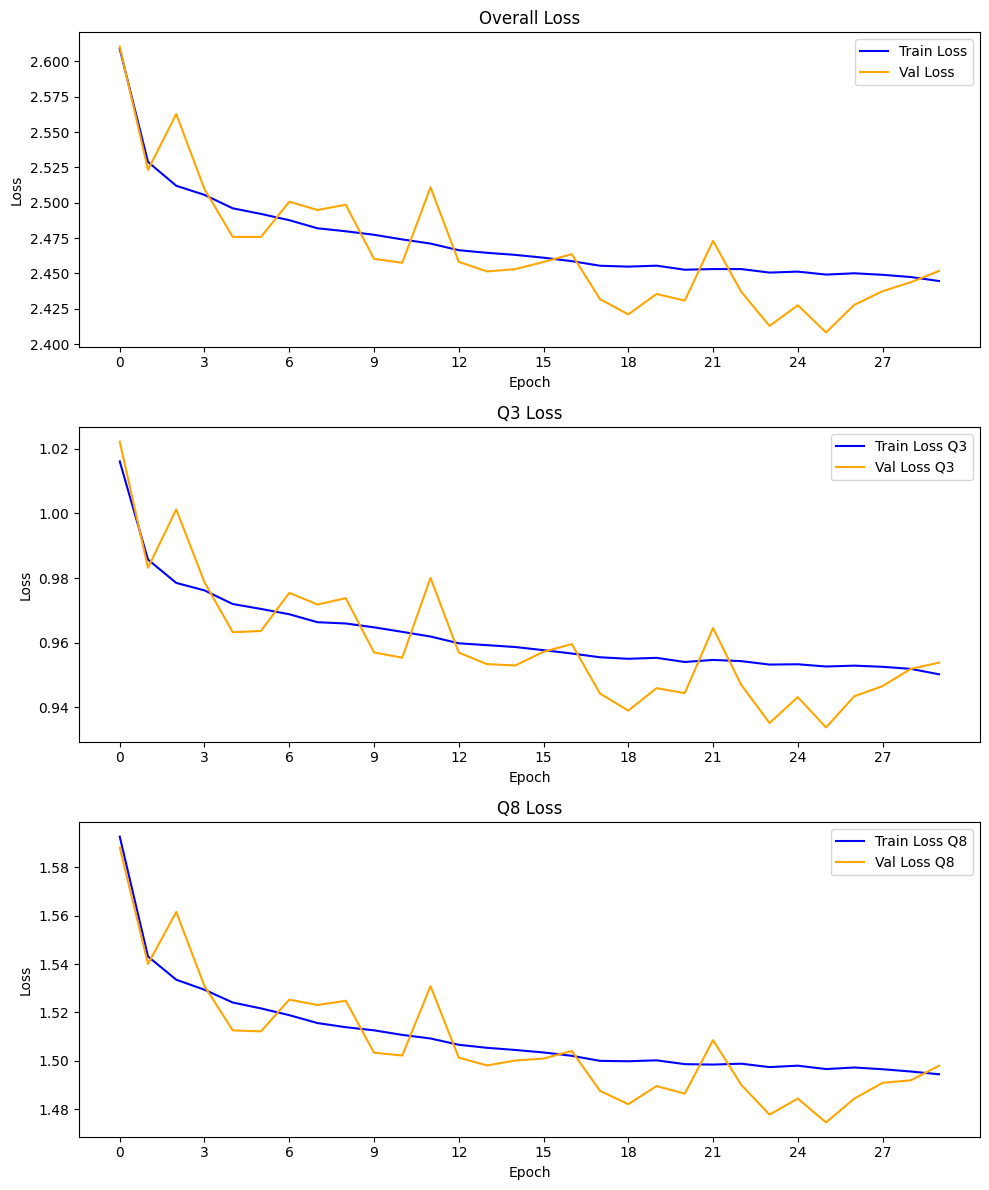

In [ ]:
plot_loss_curves(
    train_losses=model_results['train_losses'],
    val_losses=model_results['val_losses'],
    train_losses_q3=model_results['train_losses_q3'],
    val_losses_q3=model_results['val_losses_q3'],
    train_losses_q8=model_results['train_losses_q8'],
    val_losses_q8=model_results['val_losses_q8']
)

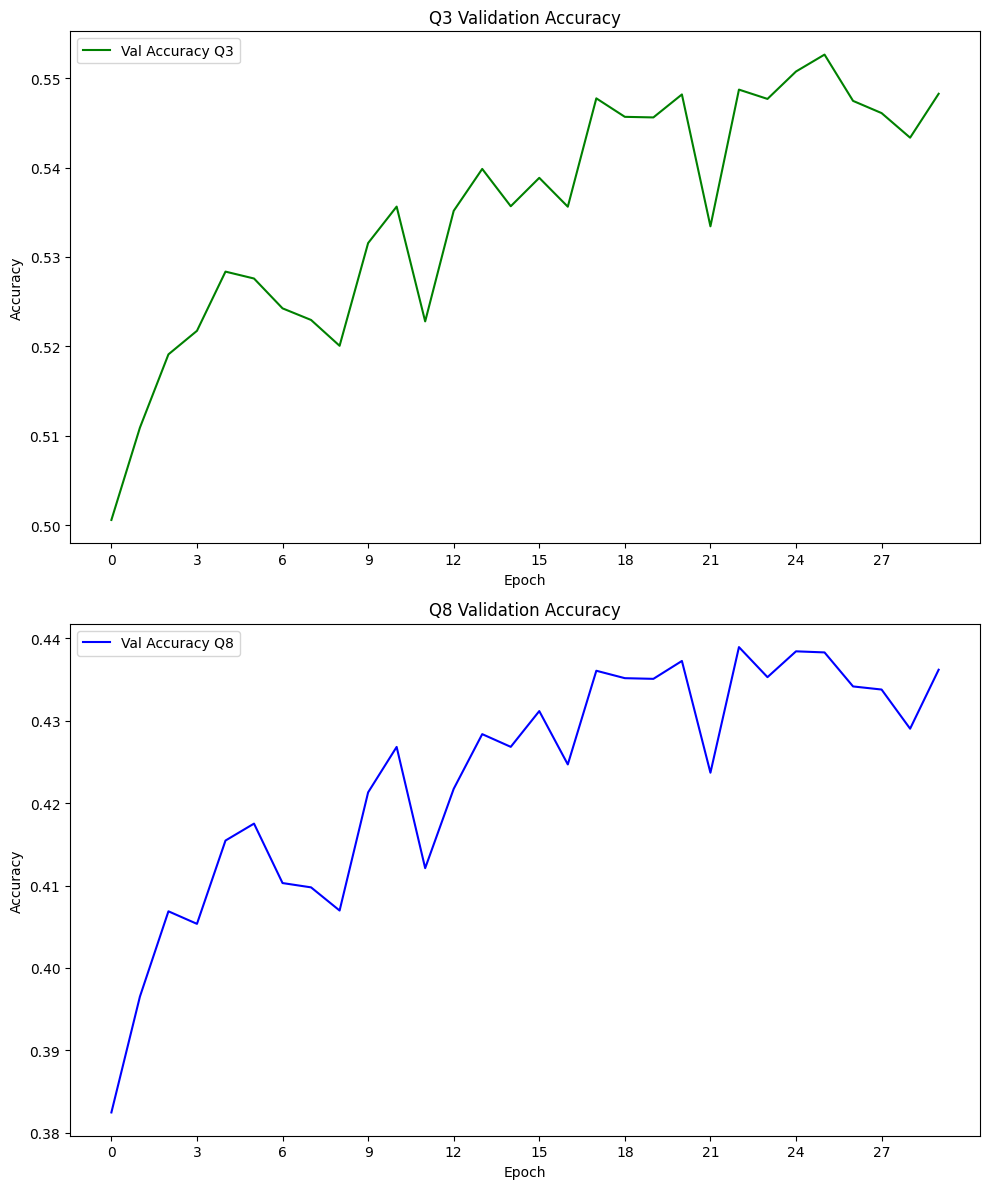

In [ ]:
plot_val_accuracy_curves(
    val_accs_q3=model_results['val_accs_q3'],
    val_accs_q8=model_results['val_accs_q8']
)

In [25]:
test_metrics = test_step(model, test_loader, criterion)
pprint(test_metrics)

{'loss': 2.3958981333838567,
 'loss_q3': 0.9293233201238844,
 'loss_q8': 1.4665748108757868,
 'metrics_q3': {'accuracy': np.float64(0.5544344716367962),
                'f1': 0.5053017726054275,
                'precision': 0.5365664061159016,
                'recall': 0.5122093523069224},
 'metrics_q8': {'accuracy': np.float64(0.444220392538727),
                'f1': 0.2225938937670793,
                'precision': 0.23308102738466874,
                'recall': 0.2414540284908646}}
